In [11]:
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [5]:
COLORS = [
    '#00B0F0',
    '#FF0000'
]

# Chapter 03

In this chapter we focus on building an intuition between causal concepts and linear regression. Next, we move to a comparison between observational and interventional distributions and show why and how they might be different. Finally, we introduce the concept of structural models. Structural models will naturally lead us to the concept of graphical models in the next chapter.

## Regression

Let's build a model according to the followingh specification:

$$\Large \hat{y}_i = 1.12 + 0.93x_i + 0.5 \epsilon_i$$

where $\epsilon \sim \mathcal{N}(0, 1)$

In [6]:
# Set the seed for reproducibility
np.random.seed(45)

# No. of samples
N_SAMPLES = 5000

# Define true model parameters
alpha = 1.12
beta = 0.93
epsilon = np.random.randn(N_SAMPLES)

# Generate X
X = np.random.randn(N_SAMPLES)

# Compute Y
y = alpha + beta * X + 0.5 * epsilon

# Statsmodel models require us to add constant
X = sm.add_constant(X)

print(X[:5, :])

[[ 1.          0.11530002]
 [ 1.         -0.43617719]
 [ 1.         -0.54138887]
 [ 1.         -1.64773122]
 [ 1.         -0.32616934]]


In [13]:
#How about use sklearn LinearRegression
#sklearn.linear_model.LinearRegression adds the intercept by default (unless you set fit_intercept=False)
#statsmodels.OLS does NOT add it automatically — you must explicitly add it using sm.add_constant()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,explained_variance_score,max_error
model = LinearRegression().fit(X,y)
y_pred = model.predict(X)

# Compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(y, y_pred)

# Metrics
print("🔍 Model Summary:")
print("-----------------")
print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficients: {model.coef_}")
print(f"R² Score: {r2_score(y, y_pred):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y, y_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(y, y_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y, y_pred)):.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"explained_variance_score: {explained_variance_score(y, y_pred):.4f}")
print(f"max error: {max_error(y, y_pred):.4f}")

🔍 Model Summary:
-----------------
Intercept: 1.1243
Coefficients: [0.        0.9211557]
R² Score: 0.7709
Mean Absolute Error (MAE): 0.3975
Mean Squared Error (MSE): 0.2486
Root Mean Squared Error (RMSE): 0.4986
Mean Absolute Percentage Error (MAPE): 185.79%
explained_variance_score: 0.7709
max error: 1.8878


In [7]:
# Instantiate the model and fit it
model = sm.OLS(y, X).fit()

# Print results summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 1.681e+04
Date:                Mon, 08 Sep 2025   Prob (F-statistic):               0.00
Time:                        01:58:45   Log-Likelihood:                -3615.0
No. Observations:                5000   AIC:                             7234.
Df Residuals:                    4998   BIC:                             7247.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1243      0.007    159.391      0.0

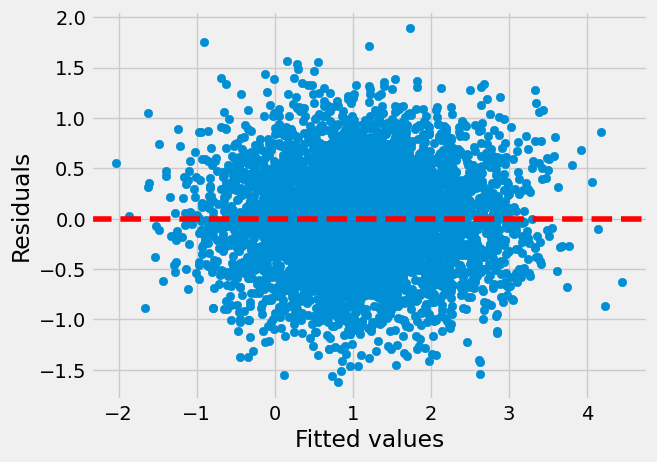

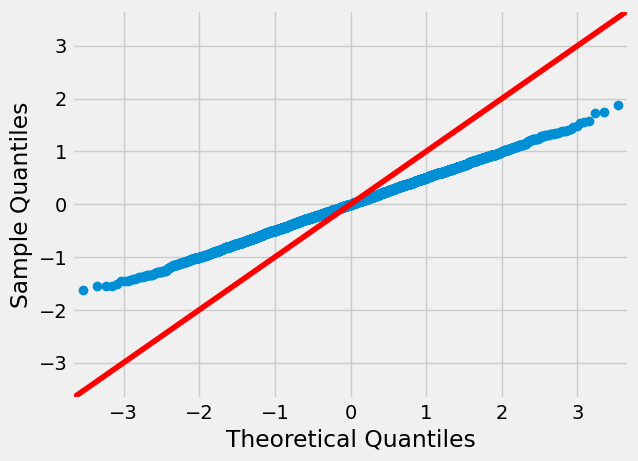

(np.float64(0.20798030644618848), np.float64(0.8659287404417664))
Durbin-Watson: 1.986023657870663
Breusch-Pagan p-value: 0.4762582249458319


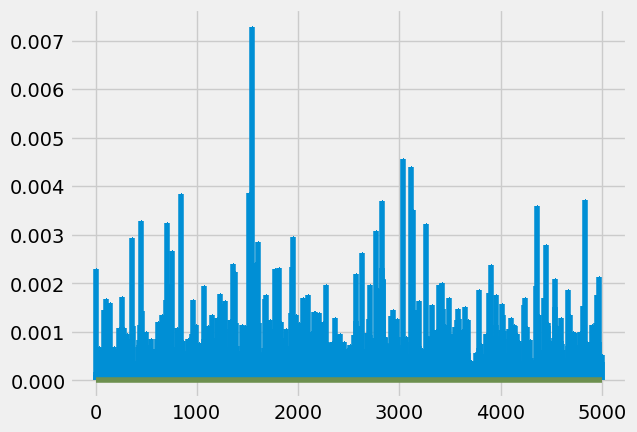

In [14]:
# Check fitness
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import het_breuschpagan, normal_ad

residuals = model.resid
fitted = model.fittedvalues

# 1. Linearity & Homoscedasticity
plt.scatter(fitted, residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted values")
plt.ylabel("Residuals")
plt.show()

# 2. Normality of residuals
sm.qqplot(residuals, line='45')
plt.show()
print(normal_ad(residuals))  # Anderson-Darling test

# 3. Independence of errors
# rule of thumb: 0.0 – 1.5 → Strong evidence of positive autocorrelation
#1.5 – 2.5 → Residuals likely independent (safe zone)
#2.5 – 4.0 → Evidence of negative autocorrelation
print("Durbin-Watson:", durbin_watson(residuals))

# 4. Multicollinearity (VIF)
#vif_data = pd.DataFrame()
#vif_data["feature"] = X.columns
#vif_data["VIF"] = [variance_inflation_factor(X.values, i)
#                   for i in range(X.shape[1])]
#print(vif_data)

# 5. Heteroscedasticity (Breusch-Pagan test)
# Rule of thumb: if p-value is small, means there is residual can be explained by vars which means heteroscedasticity
bp_test = het_breuschpagan(residuals, model.model.exog)
print("Breusch-Pagan p-value:", bp_test[1])

# 6. Outliers & Influence
# Rule of thumb: cook_distance > 1 highly influential, 0.5-1 could be concerning
influence = model.get_influence()
(c, p) = influence.cooks_distance
plt.stem(range(len(c)), c, markerfmt=",")
plt.show()

In [25]:
# Generate predictions
y_pred = fitted_model.predict(X)

AttributeError: 'Legend' object has no attribute 'legendHandles'

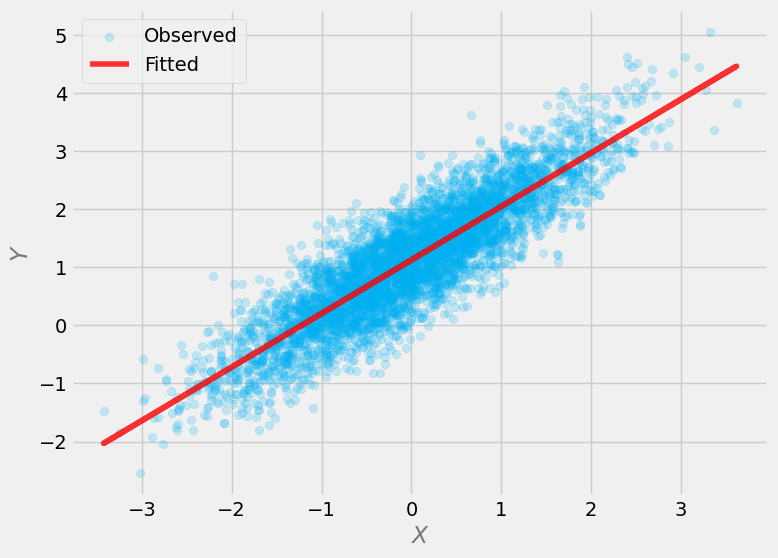

In [26]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 1], y, color=COLORS[0], label='Observed', alpha=.2)
plt.plot(X[:, 1], y_pred, color=COLORS[1], label='Fitted', alpha=.8)
plt.xlabel('$X$', alpha=.5)
plt.ylabel('$Y$', alpha=.5)
legend = plt.legend()

# Set opacity for the legend
[l.set_alpha(.8) for l in legend.legendHandles]

plt.show()

### Reversed model

Now we're going to reverse the ordering of variables and regress $X$ on $Y$.

In [27]:
# Let's remove the constant (now X becomes our target variable)
x_rev = X[:, 1]

# Let's add constant (now Y becomes our predictor)
Y_rev = sm.add_constant(y)

In [28]:
# Instantiate the model and fit it
model_rev = sm.OLS(x_rev, Y_rev)
fitted_model_rev = model_rev.fit()

# Print results summary
print(fitted_model_rev.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                 1.681e+04
Date:                Sun, 07 Sep 2025   Prob (F-statistic):               0.00
Time:                        21:08:41   Log-Likelihood:                -3375.0
No. Observations:                5000   AIC:                             6754.
Df Residuals:                    4998   BIC:                             6767.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9441      0.010    -96.048      0.0

In [19]:
#How about use sklearn LinearRegression
#sklearn.linear_model.LinearRegression adds the intercept by default (unless you set fit_intercept=False)
#statsmodels.OLS does NOT add it automatically — you must explicitly add it using sm.add_constant()

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,explained_variance_score,max_error
model = LinearRegression().fit(Y_rev,x_rev)
X_pred = model.predict(Y_rev)

# Compute MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


# Metrics
print("🔍 Model Summary:")
print("-----------------")
print(f"Intercept: {model.intercept_:.4f}")
print(f"Coefficients: {model.coef_}")
print(f"R² Score: {r2_score(x_rev, X_pred):.4f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(x_rev, X_pred):.4f}")
print(f"Mean Squared Error (MSE): {mean_squared_error(x_rev, X_pred):.4f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(x_rev, X_pred)):.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mean_absolute_percentage_error(x_rev, X_pred):.2f}%")
print(f"explained_variance_score: {explained_variance_score(x_rev, X_pred):.4f}")
print(f"max error: {max_error(x_rev, X_pred):.4f}")

🔍 Model Summary:
-----------------
Intercept: -0.9441
Coefficients: [0.         0.83684148]
R² Score: 0.7709
Mean Absolute Error (MAE): 0.3784
Mean Squared Error (MSE): 0.2259
Root Mean Squared Error (RMSE): 0.4752
Mean Absolute Percentage Error (MAPE): 943.33%
explained_variance_score: 0.7709
max error: 1.9685


In [29]:
# Generate predictions
x_pred_rev = fitted_model_rev.predict(Y_rev)

AttributeError: 'Legend' object has no attribute 'legendHandles'

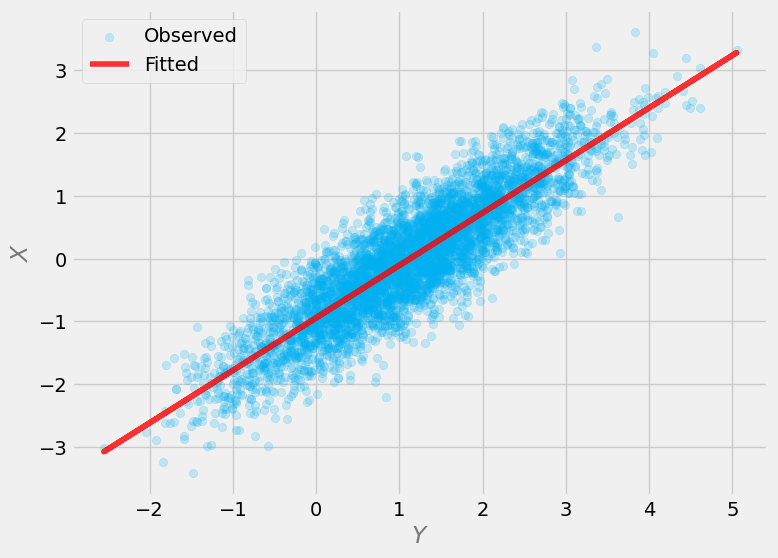

In [30]:
# Plot
plt.figure(figsize=(8, 6))
plt.scatter(Y_rev[:, 1], x_rev, color=COLORS[0], label='Observed', alpha=.2)
plt.plot(Y_rev[:, 1], x_pred_rev, color=COLORS[1], label='Fitted', alpha=.8)
plt.xlabel('$Y$', alpha=.5)
plt.ylabel('$X$', alpha=.5)
legend = plt.legend()

# Set opacity for the legend
[l.set_alpha(.8) for l in legend.legendHandles]

plt.show()

## Should we always control for all available covariates?

### Example

#### Visualize the model

To correctly render the graphs you need to install graphviz backend.

More details: https://pypi.org/project/graphviz/

In [31]:
import graphviz

In [32]:
# Create a directed graph
g_1 = graphviz.Digraph(format='png')

# Add nodes
nodes_1 = ['A', 'X', 'B', 'Y']
[g_1.node(n) for n in nodes_1]

g_1.edges(['AX', 'XB', 'AY', 'YB'])

In [33]:
# Render for print
g_1.render('img/ch_03_graph_01')

'img/ch_03_graph_01.png'

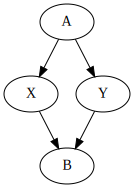

In [34]:
# Display the graph
g_1

In [ ]:
# Set random seed for reproducibility
np.random.seed(45)

# Define the sample size
N_SAMPLES = 1000

# Build the graph (note that the coefficients are arbitrarily chosen)
a = np.random.randn(N_SAMPLES)
x = 2 * a + 0.5 * np.random.randn(N_SAMPLES)
y = 2 * a + 0.5 * np.random.randn(N_SAMPLES)
b = 1.5 * x + 0.75 * y

In [ ]:
# Define four model variants
variants = [
    [x],
    [x, a],
    [x, b],
    [x, a, b]
]

# Fit models iteratively and store the results
results = []
for variant in variants:
    X = sm.add_constant(np.stack(variant).T)

    # Instantiate the model and fit it
    model = sm.OLS(y, X)
    fitted_model = model.fit()

    results.append((fitted_model.params, fitted_model.pvalues))

    print(f'Params: {fitted_model.params.round(3)}')
    print(f'p-vals: {fitted_model.pvalues.round(3)}')
    print(f'Signif: {fitted_model.pvalues <= .05}\n')

Params: [-0.02   0.947]
p-vals: [0.359 0.   ]
Signif: [False  True]

Params: [-0.011  0.014  1.967]
p-vals: [0.488 0.657 0.   ]
Signif: [False False  True]

Params: [-0.    -2.     1.333]
p-vals: [0.133 0.    0.   ]
Signif: [False  True  True]

Params: [ 0.    -2.     0.     1.333]
p-vals: [0. 0. 0. 0.]
Signif: [ True  True  True  True]



In [ ]:
# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.882
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     7477.
Date:                Thu, 09 Jun 2022   Prob (F-statistic):               0.00
Time:                        19:40:09   Log-Likelihood:                -1062.2
No. Observations:                1000   AIC:                             2128.
Df Residuals:                     998   BIC:                             2138.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0204      0.022     -0.918      0.3

## Regression and structural models

In [ ]:
# Create a directed graph
g_2 = graphviz.Digraph(
    format='png',
    graph_attr={
        'rankdir':'LR',
        'ranksep': '.6',
        'nodesep': '1.5'
    })

# Add nodes
nodes_2 = ['A', 'X', 'Y']
[g_2.node(n) for n in nodes_2]

g_2.edges(['AY', 'AX', 'XY'])

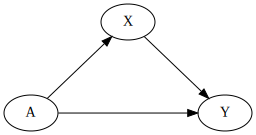

In [ ]:
g_2

In [ ]:
# Render for print
g_2.render('img/ch_03_graph_02')

'img\\ch_03_graph_02.png'

In [ ]:
# Set random seed for reproducibility
np.random.seed(45)

# Define the sample size
N_SAMPLES = 1000

# Define the SCM
a = np.random.randn(N_SAMPLES)
x = 2 * a + .7 * np.random.randn(N_SAMPLES)
y = 2 * a + 3 * x + .75 * x**2

In [ ]:
# Statsmodel models require us to add constant
X = sm.add_constant(np.stack([x, x**2, a]).T)

# Instantiate the model and fit it
model = sm.OLS(y, X)
fitted_model = model.fit()

# Print results summary
print(fitted_model.summary(xname=['const', 'x', 'x^2', 'a']))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.294e+32
Date:                Sun, 05 Mar 2023   Prob (F-statistic):               0.00
Time:                        12:51:10   Log-Likelihood:                 30899.
No. Observations:                1000   AIC:                        -6.179e+04
Df Residuals:                     996   BIC:                        -6.177e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -2.22e-16   3.57e-16     -0.622      0.5